#  Trabajo Práctico 4

    Integrantes: Alvarez Vico Jazmín LU: 75/15
                 Cortés Conde Titó Javier LU: 252/15
                 Frassia Fernando Nicolás LU: 340/13

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation.clustering_coefficient as nx_cluster
import networkx.algorithms.shortest_paths.generic as nx_shortest_path
import random
import warnings
warnings.filterwarnings('ignore')

# 1) Creación del grafo.

## Generación del grafo

In [2]:
def cargar_datos(filename):
    df = pd.read_csv(filename, sep=',', error_bad_lines=False, header = None)
    df.drop([0,1,2,4], axis = 1, inplace = True)

    df[3] = df[3].astype(str)
    
    lista_inter_autores = [((x.iat[0]).lstrip()).split(" & ") for index, x in df.iterrows()]
    lista_inter_autores

    grafo = nx.Graph()
    for autores in lista_inter_autores:
        if len(autores) == 1:
            grafo.add_node(autores[0])
        else:
            vecinos = lista_pares(autores)
            grafo.add_edges_from(vecinos)

    return grafo

def lista_pares(autores):
    lista = []
    for i in range(len(autores) -1):
        for j in range(i+ 1, len(autores)):
            aux = (autores[i], autores[j])
            lista.append(aux)
    return lista


grafo = cargar_datos('data.csv')


b'Skipping line 14: expected 5 fields, saw 6\nSkipping line 49: expected 5 fields, saw 6\nSkipping line 55: expected 5 fields, saw 6\nSkipping line 74: expected 5 fields, saw 6\nSkipping line 76: expected 5 fields, saw 7\nSkipping line 82: expected 5 fields, saw 7\nSkipping line 84: expected 5 fields, saw 6\nSkipping line 98: expected 5 fields, saw 6\nSkipping line 142: expected 5 fields, saw 6\nSkipping line 144: expected 5 fields, saw 6\nSkipping line 159: expected 5 fields, saw 6\nSkipping line 177: expected 5 fields, saw 6\nSkipping line 221: expected 5 fields, saw 6\nSkipping line 224: expected 5 fields, saw 6\nSkipping line 287: expected 5 fields, saw 6\nSkipping line 322: expected 5 fields, saw 6\nSkipping line 324: expected 5 fields, saw 6\nSkipping line 325: expected 5 fields, saw 6\nSkipping line 326: expected 5 fields, saw 6\nSkipping line 354: expected 5 fields, saw 6\nSkipping line 386: expected 5 fields, saw 12\nSkipping line 398: expected 5 fields, saw 7\nSkipping line 3

In [3]:
histo = nx.degree_histogram(grafo)

## Número de nodos y aristas

In [4]:
print('Cantidad de nodos: ', len(grafo.nodes()))
print('Cantidad de aristas: ', len(grafo.edges()))

Cantidad de nodos:  3878
Cantidad de aristas:  7489


## Representación gráfica del grafo

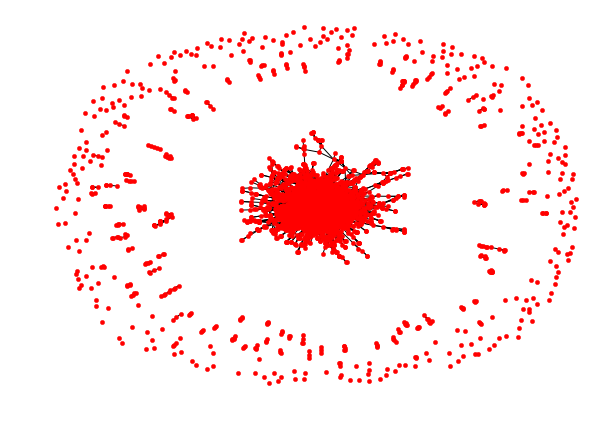

In [5]:
grafo_filtrado = grafo

for component in list(nx.connected_component_subgraphs(grafo_filtrado)):
    if len(component.nodes()) == 2:
        grafo_filtrado.remove_nodes_from(component)

nx.draw(grafo_filtrado, node_size=20)
plt.show()

Decidimos quitar las componentes conexas de dos nodos, para limpiar el grafo visualmente. Se puede ver que la mayoría de los autores están dentro de una gran componente conexa.

# 2) Distribución de Grado
## Escala lineal

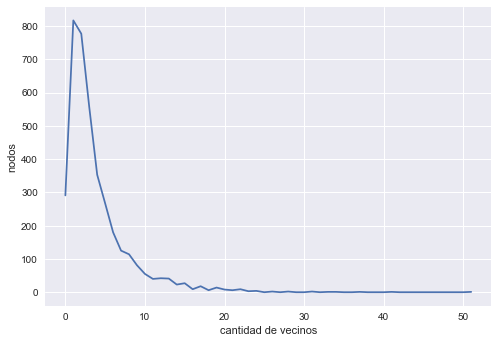

In [6]:
plt.plot(histo)
plt.xlabel("cantidad de vecinos")
plt.ylabel("nodos")
plt.show()

## Escala semilogarítmica eje y.

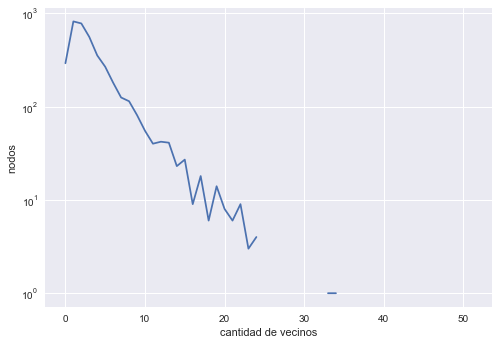

In [7]:
plt.semilogy(histo)
plt.xlabel("cantidad de vecinos")
plt.ylabel("nodos")
plt.show()

## Escala logarítmica, eje x e y.

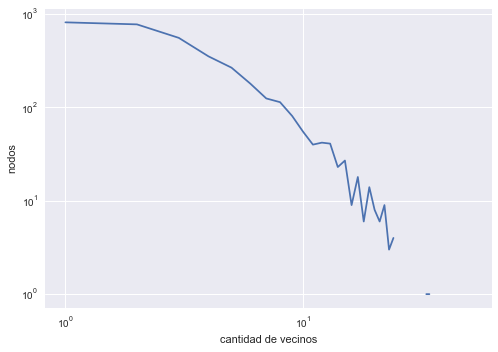

In [8]:
plt.loglog(histo)
plt.xlabel("cantidad de vecinos")
plt.ylabel("nodos")
plt.show()

Tras ver los gráficos de la distribución del grado de los autores, nos parece evidente que sigue una distribución exponencial.

# 3) Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor (componente gigante).

In [9]:
print("Cantidad de componentes conexas: ", nx.algorithms.components.number_connected_components(grafo))

def componentes_conexas_no_triviales():
    grafo_filtrado = grafo
    for component in list(nx.connected_component_subgraphs(grafo_filtrado)):
        if len(component.nodes()) == 1:
            grafo_filtrado.remove_nodes_from(component)
    return len(list(nx.connected_component_subgraphs(grafo_filtrado)))

print("Cantidad de componentes conexas quitando nodos aislados: ", componentes_conexas_no_triviales())

mayor_componente = max(nx.algorithms.components.connected_component_subgraphs(grafo), key = len)
print("Cantidad de nodos de la mayor componente conexa: ", len(mayor_componente))

Cantidad de componentes conexas:  387
Cantidad de componentes conexas quitando nodos aislados:  95
Cantidad de nodos de la mayor componente conexa:  2920


# 4) Tamaño de vecindades.

In [10]:
def vecindad_nodo(indice, mayor_componente):
    lista = list(mayor_componente.nodes())
    nodo_semilla = lista[indice]
    nodos_marcados = set(nodo_semilla)
    agregados = []
    vecinos_grado = set([n for n in mayor_componente.neighbors(nodo_semilla)])
    
    while len(nodos_marcados) < len(mayor_componente):
        vecinos_grado = vecinos_grado.difference(nodos_marcados)
        agregados.append(len(vecinos_grado))

        vecinos_grado_proximo = set([])
        for vecino in vecinos_grado:
                vecinos_grado_proximo = vecinos_grado_proximo.union(set([n for n in mayor_componente.neighbors(vecino)]))
        nodos_marcados = nodos_marcados.union(vecinos_grado)

        vecinos_grado = vecinos_grado_proximo
    return agregados

def vecindad_nodos(conjunto_indice, mayor_componente):
    lista_distribuciones = []
    for ind in conjunto_indice:
        lista_agregados = vecindad_nodo(ind, mayor_componente)
        lista_distribuciones.append(lista_agregados)
    return lista_distribuciones


In [11]:
set_semillas_random = set(list(map(lambda x: random.randint(0, len(mayor_componente)-1), range(20))))
lista_distribuciones = vecindad_nodos(set_semillas_random, mayor_componente)

## Total autores alcanzados por distancia

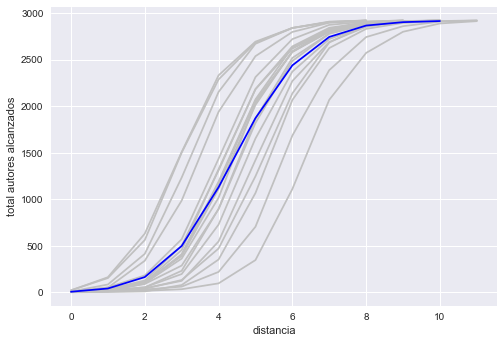

In [12]:
def addPreviousElements(lista):
    list_with_added_elements = []
    current_added = 0
    for element in lista:
        current_added = current_added + element
        list_with_added_elements.append(current_added)
    return list_with_added_elements

lista_alcanzados = []
for dist in lista_distribuciones:
    lista_alcanzados.append(addPreviousElements(dist))
    
for dist in lista_alcanzados:
    plt.plot(dist, 'silver')
    
max_length_dist = 0
for dist in lista_alcanzados:
    max_length_dist = max(max_length_dist, len(dist))

mean_dist = []
for i in range(max_length_dist-1):
    i_elements = []
    for dist in lista_alcanzados:
        if len(dist) > i:
            i_elements.append(dist[i])
    mean_dist.append(np.mean(i_elements))

plt.plot(mean_dist, 'blue')
plt.xlabel('distancia')
plt.ylabel('total autores alcanzados')
plt.show()

## Nuevos autores alcanzados por distancia

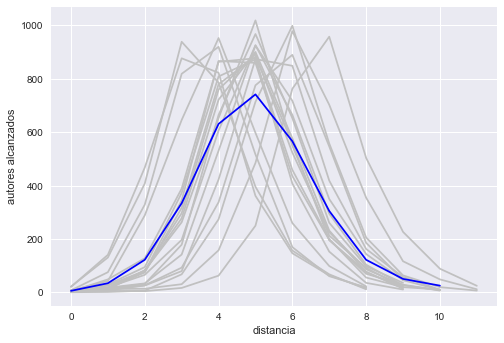

máximo índice:  5
máxima cantidad de autores nuevos agregados:  741.947368421


In [13]:
for dist in lista_distribuciones:
    plt.plot(dist, 'silver')
    
max_length_dist = 0
for dist in lista_distribuciones:
    max_length_dist = max(max_length_dist, len(dist))

mean_dist = []
for i in range(max_length_dist-1):
    i_elements = []
    for dist in lista_distribuciones:
        if len(dist) > i:
            i_elements.append(dist[i])
    mean_dist.append(np.mean(i_elements))

plt.plot(mean_dist, 'blue')
plt.xlabel('distancia')
plt.ylabel('autores alcanzados')
plt.show()

argmax = [i for i, j in enumerate(mean_dist) if j == max(mean_dist)]
print('máximo índice: ', argmax[0])
print('máxima cantidad de autores nuevos agregados: ', max(mean_dist))

## Observaciones y relación con fenómeno de seis grados de separación

Tras correr el experimento para 20 nodos semilla diferentes observamos que el fenómeno de seis grados de separación es consistente con los mismos. Más aún, observamos que los gráficos forman una campana de gauss, representando así una distribución normal.

# 5) Mundos pequeños

## Coeficiente de clustering C y media de caminos mínimos

In [14]:
clustering_c = nx_cluster.average_clustering(mayor_componente)
print('coeficiente de clustering C: ', clustering_c)

mean_shortest_path = nx_shortest_path.average_shortest_path_length(mayor_componente)
print('media de caminos mínimos: ', mean_shortest_path)

coeficiente de clustering C:  0.495
media de caminos mínimos:  6.213882123264207


## Grafo aleatorio con misma distribución de grados

In [15]:
def secuencia_de_grados(g):
    grados = []
    for node in g.nodes():
        grados.append(len(g.neighbors(node)))
    return grados

grafo_aleatorio = nx.expected_degree_graph(secuencia_de_grados(grafo))

mayor_componente_aleatorio = max(nx.algorithms.components.connected_component_subgraphs(grafo_aleatorio), key = len)
clustering_c_aleatorio = nx_cluster.average_clustering(mayor_componente_aleatorio)
print('coeficiente de clustering C del grafo aleatorio: ', clustering_c_aleatorio)

mean_shortest_path_aleatorio = nx_shortest_path.average_shortest_path_length(mayor_componente_aleatorio)
print('media de caminos mínimos del grafo aleatorio: ', mean_shortest_path_aleatorio)

coeficiente de clustering C del grafo aleatorio:  0.005
media de caminos mínimos del grafo aleatorio:  4.708968391526596


## Interpretación

Podemos observar que el coeficiente de clustering C del grafo aleatorio es casi nulo, mientras que el del original era de 0.49. Por otro lado, la media de caminos mínimos es también menor, aunque no por tanto. Esto nos da a entender que el grafo aleatorio no es un ejemplo de un grafo con estructura de mundos pequeños, y que generar uno requiere mayor delicadeza que simplemente respetar la secuencia de grados original.

# 6) Estrellas

## Por grado de centralidad

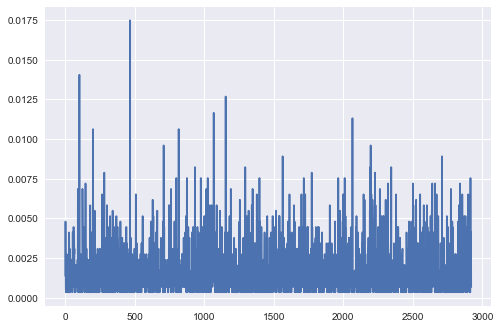

In [16]:
grafo_degree_centrality = nx.algorithms.centrality.degree_centrality(mayor_componente)

y = []
for key, value in grafo_degree_centrality.items():
    y.append(value)
x = range(len(y))
plt.plot(x,y)
plt.show()


Observando gráficamente el valor de centralidad de cada autor, decidimos tomar arbitrariamente a los que superan  el 0.01, y estos serán los estrellas bajo esta métrica.

In [31]:
estrellas_centrality = {}
for key, value in grafo_degree_centrality.items():
    if value >= 0.01:
        estrellas_centrality[key] = value
print('Estrellas por grado de centralidad: ', estrellas_centrality)

Estrellas por grado de centralidad:  {'Ambjorn': 0.014045906132237067, 'Strominger': 0.010620075368276808, 'Lee': 0.01747173689619733, 'Vafa': 0.010620075368276808, 'Park': 0.011647824597464886, 'Kim': 0.012675573826652964, 'Ferrara': 0.011305241521068859}


## Por betweenness

In [18]:
grafo_betweenness = nx.algorithms.centrality.betweenness_centrality(mayor_componente)

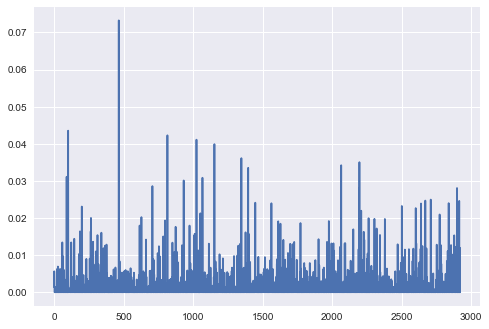

In [19]:
y = []
for key, value in grafo_betweenness.items():
    y.append(value)
x = range(len(y))
plt.plot(x,y)
plt.show()

Nuevamente, viendo gráficamente el valor de betweenness de cada autor, decidimos tomar arbitrariamente a los que superan el 0.03, y estos serán los estrellas bajo esta métrica.

In [32]:
estrellas_betweenness = {}
for key, value in grafo_betweenness.items():
    if value >= 0.03:
        estrellas_betweenness[key] = value
print('Estrellas por betweenness: ', estrellas_betweenness)

Estrellas por betweenness:  {'Suzuki': 0.031096311849195948, 'Ambjorn': 0.0435352042888685, 'Lee': 0.07324743190154448, 'Vafa': 0.042280413560006135, 'Klebanov': 0.030113049422981878, 'Kogan': 0.04110644442630227, 'Park': 0.030844502834940793, 'Kim': 0.03989571080031323, 'Li': 0.036122653827300455, 'Ohta': 0.03351505873329173, 'Ferrara': 0.03421630685577251, 'Gibbons': 0.03504054350105672}


## Desaparición de estrellas

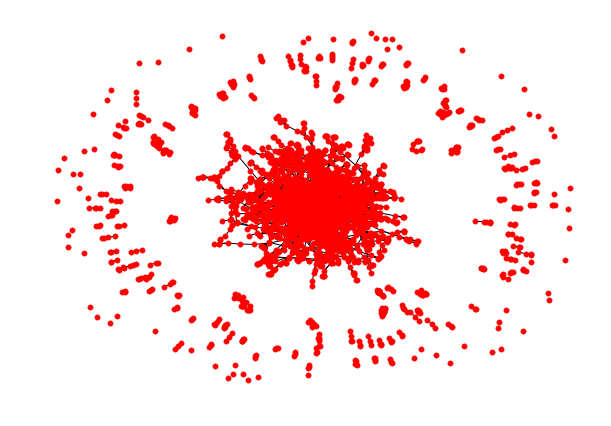

In [30]:
grafo_sin_estrellas = grafo

estrellas = set()
for key, value in estrellas_betweenness.items():
    estrellas.add(key)
for key, value in estrellas_centrality.items():
    estrellas.add(key)

grafo_sin_estrellas.remove_nodes_from(estrellas)

for component in list(nx.connected_component_subgraphs(grafo_sin_estrellas)):
    if len(component.nodes()) == 2:
        grafo_sin_estrellas.remove_nodes_from(component)

nx.draw(grafo_sin_estrellas, node_size=30)
plt.show()

Tras quitar todos los autores estrellas bajo nuestras métricas, no pudimos ver cambios a simple vista en el grafo y mucho menos hacer desaparecer la componente gigante. Nuestra idea es que quizás estas métricas por sí solas no son lo suficientemente fuertes como para identificar a los autores estrella que (al removerlos) podrían hacer desaparecer tal componente.

# Javi: Esto de abajo no me acuerdo para qué estaba

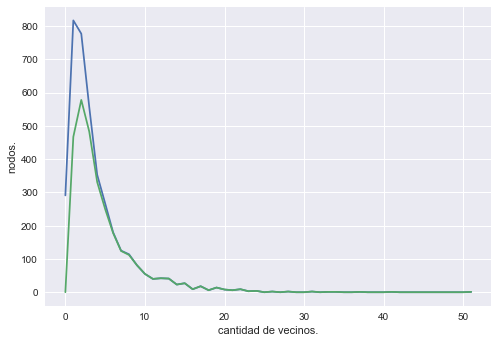

In [22]:
histo_comp = nx.degree_histogram(mayor_componente)

plt.plot(histo)
plt.plot(histo_comp)
plt.xlabel("cantidad de vecinos.")
plt.ylabel("nodos.")
plt.show()